Author: Amina Nsanza 
Class: 5550 Data Science and Climate Change. 
Project: Rising Temperature Impact on Energy Poverty
Code Source: Analyzing, Model Development &  Predicting Final Datasets

In [1]:
import pandas as pd 
import polars as pl 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from codecarbon import EmissionsTracker
from sklearn.compose import ColumnTransformer

In [13]:
tidy_index_past_weather = pd.read_csv('Cleaned_Data/tidy_index_past_weather.csv' )
tidy_index_past_weather.head()

tidy_future_weather = pd.read_csv('Cleaned_Data/tidy_future_weather.csv' )

tidy_future_weather.head()

,Continental Region,Year,Weather Anomaly
0,Africa,2035,0.9
1,Africa,2065,1.2
2,Africa,2100,1.1
3,Africa,2035,0.9
4,Africa,2065,1.3


Methodology: A correlation matrix will be used to explore the relationship between energy prices and weather temperatures. This analysis will help determine the appropriate model to apply to the dataset for further exploration. (This differes from initial methodology of a regression model)

Correlation Matrix to see if there is a corr between energy poverty index and weather anamoalies in the past weather anomalies and poverty indexes. 

Pearson Correlation Matrix

In [12]:
tidy_index_past_weather.head()

correlation_matrix = tidy_index_past_weather[['Poverty Index', 'Weather Anomaly']].corr(method='pearson')
correlation_matrix



,Poverty Index,Weather Anomaly
Poverty Index,1.000000,-0.115175
Weather Anomaly,-0.115175,1.000000


Pearson Results: -0.115. There is a weak negative correlation between the 2 variables. 
So the temp anomalies increase slightly, energy poverty  decrease slightly, this is against the initial asumption. However this negative correlation is not significant and hihgky suggests that there is no linear correlation between temperature anomalies and poverty index. 

Spearman Corr 

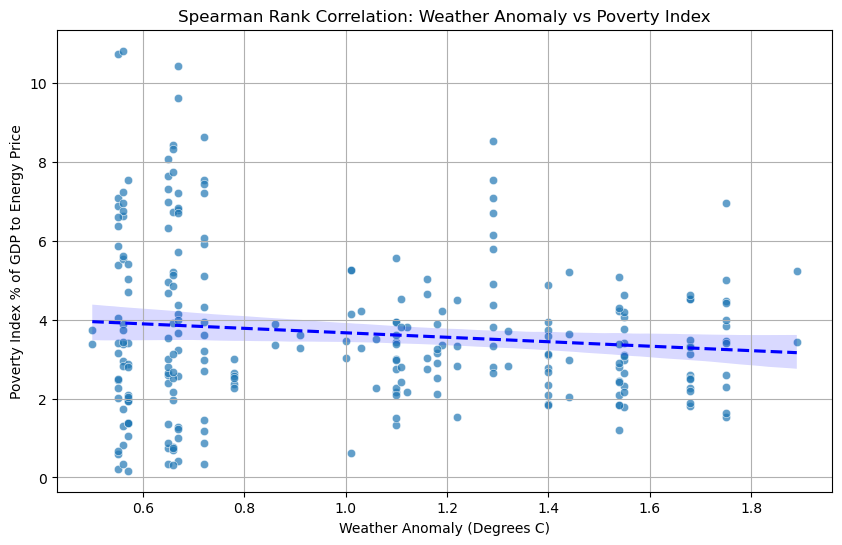

(-0.0358039305908103, 0.5662340744227682)

In [ ]:
spearman_corr, spearman_p_value = stats.spearmanr(tidy_index_past_weather['Poverty Index'], tidy_index_past_weather['Weather Anomaly'])


# plot to visualize the  correlation 
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tidy_index_past_weather['Weather Anomaly'], y=tidy_index_past_weather['Poverty Index'], alpha=0.7)
sns.regplot(x=tidy_index_past_weather['Weather Anomaly'], y=tidy_index_past_weather['Poverty Index'], scatter=False, color='blue', line_kws={'linestyle': '--'})
plt.title('Spearman Rank Correlation: Weather Anomaly vs Poverty Index')
plt.xlabel('Weather Anomaly (Degrees C)')
plt.ylabel('Poverty Index % of GDP to Energy Price')
plt.grid(True)
plt.show()


#results of the correlation. 
spearman_corr, spearman_p_value

This also shows a very small negative correlation. The correlation coefficient is very close to zero, meaning there is little to no monotonic relationship between energy poverty and temperature anomalies, the p-value also reinforces this showing that there is no statistical significance between these variables.  -> With this findings of both correlation matrix a regression model would not be the best to use as a predicton so we have changed to use a random forest instead. -> Also re-introducing other cols that were dropped before. energy consumption price, gdp and 

Random Forest Model. 

In [2]:
#Data with re-introduced cols -> gdp, consumption price and index and weather 

tidy_energy_index_past_weather = pd.read_csv('Cleaned_Data/tidy_energy_index_past_weather.csv')
tidy_energy_index_past_weather.head()



,Continental Region,Country Name,Year,Consumption Price,GDP,Poverty Index,Weather Anomaly
0,Africa,Algeria,2014,1.255473e+09,2.138100e+11,0.587191,0.55
1,Africa,Algeria,2015,1.376595e+09,1.659790e+11,0.829379,0.56
2,Africa,Algeria,2016,1.593000e+09,1.600340e+11,0.995413,0.67
3,Africa,Algeria,2017,1.490684e+09,1.700970e+11,0.876373,0.72
4,Africa,Algeria,2018,1.297274e+09,1.749110e+11,0.741677,0.65


In [3]:
# all features to consider in the df 
X = tidy_energy_index_past_weather[['Continental Region', 'Country Name', 'Year', 'Consumption Price', 'GDP', 'Weather Anomaly']]
Y = tidy_energy_index_past_weather['Poverty Index']

#  Including region and coountry as categorical country will not be needed after. 
preprocessor = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(drop='first'), ['Continental Region', 'Country Name'])
], remainder='passthrough')

#  Making sure the random forest is to model pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(random_state=42))
])

In [4]:
#Splitting and Predicting  & Code Carbon. 

# Spliting the data into training & testing sets 20% t0 80% 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Start tracking emissions
tracker1 = EmissionsTracker(log_level='critical', allow_multiple_runs=True)
tracker1.start()

# Training the model -> later use this to see how much carbon was used. 
pipeline.fit(X_train, Y_train)

emissions1 = tracker1.stop()

#predicting 
Y_pred = pipeline.predict(X_test)

print(f"Estimated Carbon Emissions: {emissions1:.8f} kg CO2")


[codecarbon WARNING @ 04:21:56] Multiple instances of codecarbon are allowed to run at the same time.


Estimated Carbon Emissions: 0.00000076 kg CO2


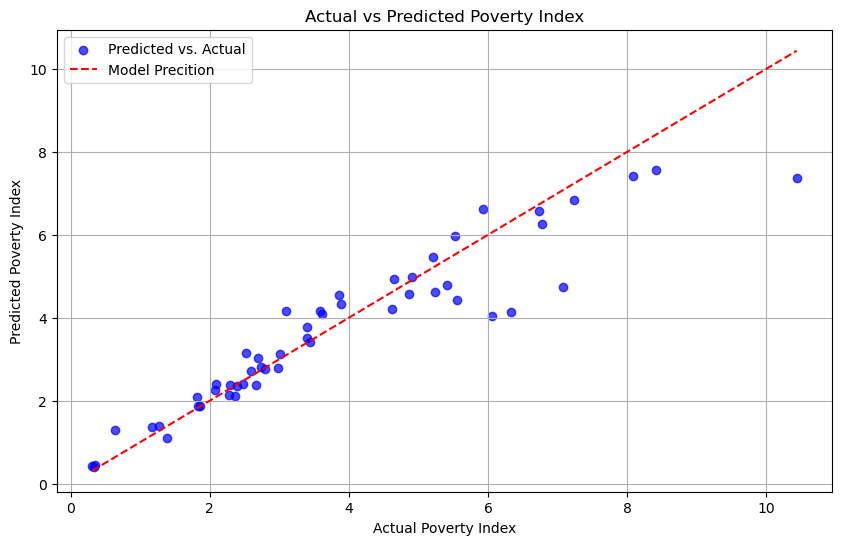

In [5]:
#Visual of Predictions compareds to the actual values. 
plt.figure(figsize=(10, 6))
plt.scatter(Y_test, Y_pred, alpha=0.7, label='Predicted vs. Actual', color='blue')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', linestyle='--', label='Model Precition')
plt.title('Actual vs Predicted Poverty Index')
plt.xlabel('Actual Poverty Index')
plt.ylabel('Predicted Poverty Index')
plt.legend()
plt.grid(True)
plt.show()


Performance Metrics 

In [6]:
# Performance metrics to evaluate and indv contribution of feature to poverty index. 
model_mse = mean_squared_error(Y_test, Y_pred)
model_r2 = r2_score(Y_test, Y_pred)

model_mse, model_r2 #checks out not the best but not bad 

(0.6278222061338092, 0.8742072203212711)

The model's performance metrics indicate room for improvement. The model is underfitting in certain areas. This suggests that additional variables, particularly economic factors, may play a significant role in predicting energy poverty, beyond just weather-related data. Further exploration of these variables could enhance the model's predictive accuracy. Hoever this model will still be used to predict future energy poverty indexes. 

In [8]:


#Score per feature that affect energy poverty from the model for Consumption Price GDP and Weather. 
feature_importance = pipeline.named_steps['model'].feature_importances_
categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out()
all_features = list(categorical_features) + ['Year', 'Consumption Price', 'GDP', 'Weather Anomaly']

# Filtering only for GDP, weather, and consumption price as the features to look at 
filtered_features = ['GDP', 'Weather Anomaly', 'Consumption Price']

importance_score = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)


importance_score = importance_score[importance_score['Feature'].isin(filtered_features)]

importance_score.reset_index(drop=True, inplace=True)
importance_score




,Feature,Importance
0,Consumption Price,0.463357
1,GDP,0.223386
2,Weather Anomaly,0.036023


As per my assumption  it is clear that multiple factors influence energy poverty indexes, with energy consumption prices being the most significant. As households spend more on energy, a greater percentage of their income is allocated toward this expense, leading to a higher energy poverty index. 

Future Prediction on Future Weather Anomalies. 

In [20]:
tidy_future_weather = pd.read_csv('Cleaned_Data/tidy_future_weather.csv' )

tidy_future_weather.head()

,Continental Region,Year,Weather Anomaly
0,Africa,2035,0.9
1,Africa,2065,1.2
2,Africa,2100,1.1
3,Africa,2035,0.9
4,Africa,2065,1.3


In [22]:
# correcting col name the column name for "Year"
tidy_future_weather.rename(columns={' Year': 'Year'}, inplace=True)


# adding placeholders for the new data that doesn;t have certain cols a placeholder column for 'Country Name' with a default value
tidy_future_weather['Consumption Price'] = tidy_energy_index_past_weather['Consumption Price'].mean()
tidy_future_weather['GDP'] = tidy_energy_index_past_weather['GDP'].mean()
tidy_future_weather['Country Name'] = 'DefaultCountry'  # Placeholder for missing column

# Ensure the columns match the training data
tidy_future_weather = tidy_future_weather[['Continental Region', 'Country Name', 'Year', 'Consumption Price', 'GDP', 'Weather Anomaly']]

# changing the preprocessor to handle unknown categories
preprocessor_updated = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), ['Continental Region', 'Country Name'])
], remainder='passthrough')

# updating the pipeline with the new preprocessor for teh new dataset. 
pipeline_new = Pipeline(steps=[
    ('preprocessor', preprocessor_updated),
    ('model', RandomForestRegressor(random_state=42))
])

#


Estimated Carbon Emissions: 0.00000045 kg CO2


/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/var/folders/19/lj7m40r97fj5_hs7nfmzyf880000gn/T/ipykernel_6759/319521807.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tidy_future_weather['Predicted Poverty Index'] = pipeline_new.predict(tidy_future_weather)


Text(0.5, 0.98, 'Predicted Energy Poverty and Weather Anomalies Over Future Years')

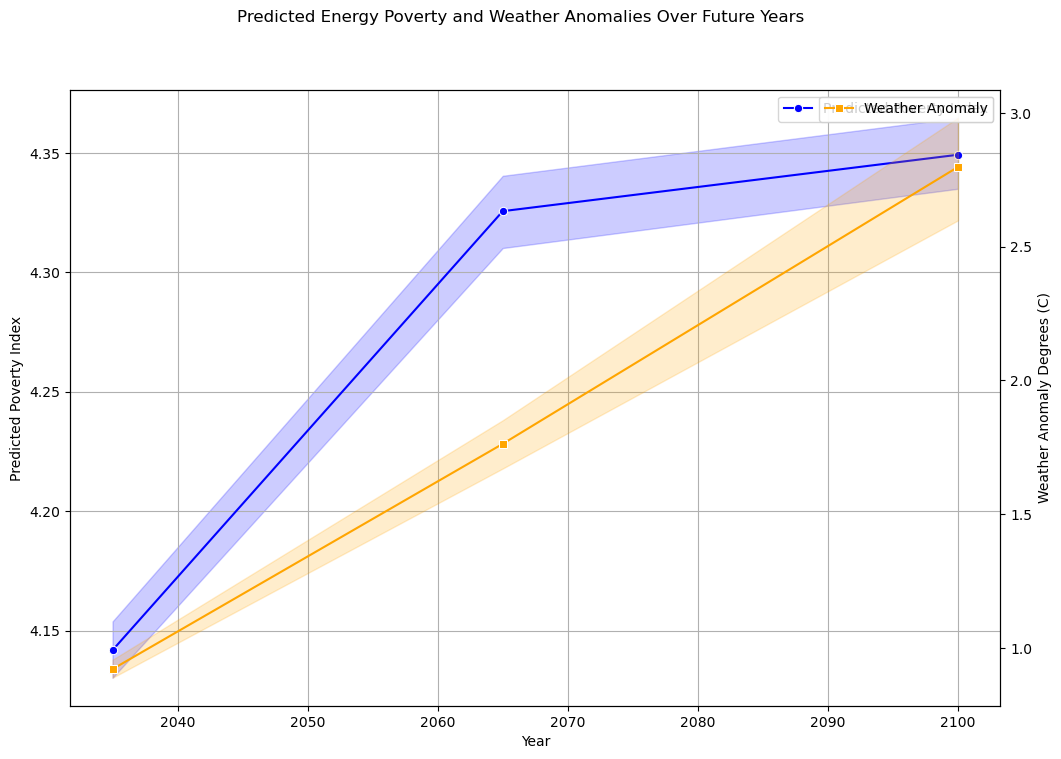

In [23]:
#Predicting and plotting. & Carbon tracker  
 
# Start tracking emissions
tracker2 = EmissionsTracker(log_level='critical', allow_multiple_runs=True)
tracker2.start()

pipeline_new.fit(X_train, Y_train)

emissions2 = tracker2.stop()
print(f"Estimated Carbon Emissions: {emissions2:.8f} kg CO2")

# Predicting  energy poverty with future temps 
tidy_future_weather['Predicted Poverty Index'] = pipeline_new.predict(tidy_future_weather)

fig, ax1 = plt.subplots(figsize=(12, 8))

# Predicted Poverty Index on the left y-axis 1st axis 
color1 = 'blue'
ax1.set_xlabel('Year', color='black') #So nothing pops out. 
ax1.set_ylabel('Predicted Poverty Index', color='black')
sns.lineplot(data=tidy_future_weather, x='Year', y='Predicted Poverty Index', marker='o', ax=ax1, color=color1, label='Predicted Poverty Index')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

# 2nd y-axis for weather anomaly
ax2 = ax1.twinx()
color2 = 'orange'
ax2.set_ylabel('Weather Anomaly Degrees (C)', color='black')
sns.lineplot(data=tidy_future_weather, x='Year', y='Weather Anomaly', marker='s', ax=ax2, color=color2, label='Weather Anomaly')
ax2.tick_params(axis='y', labelcolor='black')

fig.suptitle('Predicted Energy Poverty and Weather Anomalies Over Future Years', color='black')


Rsults: Although temperature records were not directly correlated with energy poverty, our analysis shows that rising temperatures may indirectly contribute to increased energy consumption and higher energy prices. This aligns with predictions that cooling costs will rise as temperatures increase, potentially increasing energy poverty. However, there is no strong statistical correlation suggests these predictions should be interpreted cautiously. The findings highlight the need for further research to identify all factors influencing energy poverty, including socio-economic and policy variables. Future studies should leverage more comprehensive and homogeneous datasets to explore the complex relationships between climate anomalies, economic factors, and energy poverty. This approach will help develop more accurate and actionable insights.

Model Carbon Use 

In [24]:
#First Model on PAst Temps 
print(f"Estimated Carbon Emissions: {emissions1:.8f} kg CO2") #Past Temps and years 
print(f"Estimated Carbon Emissions: {emissions2:.8f} kg CO2") #Future Temps and Future years. 



Estimated Carbon Emissions: 0.00000076 kg CO2
Estimated Carbon Emissions: 0.00000045 kg CO2
